In [22]:
import pandas as pd
import geopandas as gpd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import product
from scipy.stats import linregress

import rasterio
from rasterio.windows import Window
from rasterio.transform import Affine
from rasterio.mask import mask

from joblib import Parallel, delayed 

# import rioxarray as rxr
# import xarray as xr
# import dask.array as da
# from dask.diagnostics import ProgressBar


In [2]:
# define filepaths, objects

home = '/global/scratch/users/erin_carroll/'
tif_folder = home+'/data/tifs/GMUG_/'
years = range(2017,2025)
months = ['jul','aug','sep']
indices = ['NDMI', 'NDVI']

In [ ]:
########################
## TREND POLYGONS
########################

In [3]:
# load spatial data

gmug = gpd.read_file(home+'data/spatial_data/gmug/').to_crs(32613)
fsveg = gpd.read_file(home+'SUFHER/shp/FSVegSpatial2Feb2021.zip').to_crs(32613)
print(fsveg.crs, gmug.crs)

epsg:32613 epsg:32613


In [4]:
# filter fsveg to intersects GMUG
print(len(fsveg))
fsveg = gpd.sjoin(fsveg, gmug, op='intersects')
len(fsveg)

60283


58537

In [5]:
size_bytes = fsveg.memory_usage(deep=True).sum()
print(f"Approximate memory usage: {size_bytes / 1e6:.2f} MB")

Approximate memory usage: 242.34 MB


In [6]:
# filter fsveg to useful columns
fsveg = fsveg[['ACRES', 'COVER_TYPE', 'STAND_ID', 'geometry']].reset_index()

In [7]:
size_bytes = fsveg.memory_usage(deep=True).sum()
print(f"Approximate memory usage: {size_bytes / 1e6:.2f} MB")

Approximate memory usage: 9.13 MB


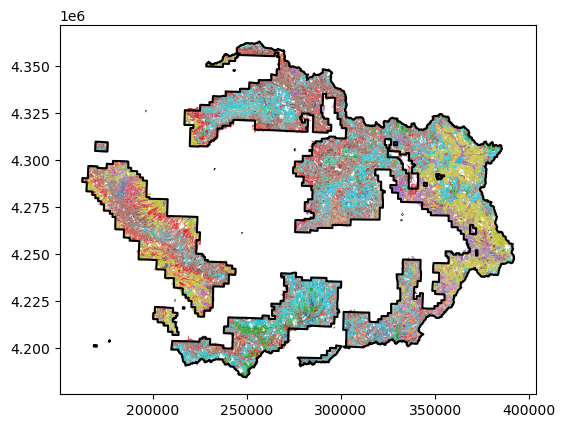

In [8]:
# visualize
fig, ax = plt.subplots()
fsveg.plot(ax=ax, column='COVER_TYPE')
gmug.boundary.plot(ax=ax, color='black')
plt.show()

In [9]:
# STAND_ID is almost but not fully unique?? Need to assign a unique id
print(len(fsveg) - len(fsveg.STAND_ID.unique()))
fsveg['unique_id'] = range(0, len(fsveg))

231


In [10]:
def raster_data_to_polygon(raster_fp, shp):
    name = raster_fp.split('/')[-1].strip('.tif')
    y = name.split('_')[0]
    m = name.split('_')[1][1:]
    idx = name.split('_')[2]
    
    stats_list = []
    with rasterio.open(raster_fp) as src:
        shp_ = shp.copy()
        # iterate over each polygon feature in the shapefile
        for index, row in shp_.iterrows():
            geometry = [row.geometry]
            
            try:
                masked_raster, _ = mask(src, geometry, crop=True, filled=True, nodata=np.nan) # Mask the raster with the polygon         
                data = masked_raster[0].flatten() # Convert masked raster to a 1D array and remove NaNs
                data = data[~np.isnan(data)]  # Remove nodata values
                if len(data) > 0:
                    min_val = np.min(data)
                    mean_val = np.mean(data)
                    max_val = np.max(data)
                    std_val = np.std(data)
                else:
                    min_val, mean_val, max_val, std_val = np.nan, np.nan, np.nan, np.nan  # Handle empty geometries
    
            except:
                min_val, mean_val, max_val, std_val = np.nan, np.nan, np.nan, np.nan  # Handle errors gracefully
    
            # Store statistics
            stats_list.append((min_val, mean_val, max_val, std_val, y, m, idx))

            
    # Convert statistics list into separate columns
    shp_[['min', 'mean', 'max', 'std', 'year', 'month', 'idx']] = stats_list
    return shp_

In [11]:
fps = sorted(glob(tif_folder+f'/*.tif'))
args = list(product(fps, [fsveg]))

dfs = Parallel(n_jobs=20)(
    delayed(raster_data_to_polygon)(raster_fp, shp) for raster_fp, shp in args
)
# started 11:12 (done 6 mins later!)

In [13]:
fsveg_ = pd.concat(dfs, ignore_index=True)
fsveg_['name'] = fsveg_['idx']+'_'+fsveg_['year']+'_'+fsveg_['month']+'_mean'
fsveg_

,index,ACRES,COVER_TYPE,STAND_ID,geometry,unique_id,min,mean,max,std,year,month,idx,name
0,0,32.25,TSF,020508550202027,"POLYGON ((274391.174 4332930.027, 274390.976 4...",0,0.025536,0.131797,0.271962,0.044391,2017,jul,NDMI,NDMI_2017_jul_mean
1,1,74.97,TAA,020507BE0102064,"POLYGON ((333586.027 4236428.430, 333598.610 4...",1,-0.01784,0.228635,0.346643,0.067949,2017,jul,NDMI,NDMI_2017_jul_mean
2,2,19.37,TAA,022402130702113,"POLYGON ((247168.243 4323317.932, 247159.526 4...",2,0.038693,0.202653,0.34815,0.048485,2017,jul,NDMI,NDMI_2017_jul_mean
3,3,29.44,TAA,020508530500592,"POLYGON ((291081.775 4270439.309, 291113.532 4...",3,0.110472,0.282901,0.385819,0.039428,2017,jul,NDMI,NDMI_2017_jul_mean
4,4,39.30,TSF,020507990900112,"POLYGON ((329293.499 4314347.808, 329291.410 4...",4,-0.199894,0.106864,0.254933,0.063328,2017,jul,NDMI,NDMI_2017_jul_mean
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2809771,60278,15.65,TBC,020507870102265,"POLYGON ((356262.671 4224106.848, 356223.476 4...",58532,0.147078,0.208191,0.371443,0.033176,2024,sep,NDVI,NDVI_2024_sep_mean
2809772,60279,26.33,TAA,020507890106105,"POLYGON ((374125.172 4252322.306, 374122.091 4...",58533,0.176759,0.423677,0.604915,0.10548,2024,sep,NDVI,NDVI_2024_sep_mean
2809773,60280,63.01,GRA,020507850208034,"POLYGON ((311911.801 4202190.323, 311960.731 4...",58534,0.093559,0.265496,0.528054,0.060669,2024,sep,NDVI,NDVI_2024_sep_mean
2809774,60281,52.36,NBA,020508110112266,"POLYGON ((292551.783 4301664.490, 292560.455 4...",58535,0.012079,0.124803,0.441315,0.059909,2024,sep,NDVI,NDVI_2024_sep_mean


In [21]:
##########################
## Run models on polygons
##########################

In [27]:
# create decimal_year time variable
month_map = {'jul': 7, 'aug': 8, 'sep': 9}
fsveg_['month_num'] = fsveg_['month'].map(month_map)
fsveg_['year'] = fsveg_['year'].astype(int)
fsveg_['mean'] = fsveg_['mean'].astype(float)


fsveg_['decimal_time'] = fsveg_['year'] + (fsveg_['month_num'] - 1) / 12

In [28]:
fsveg_['decimal_time'].unique()

array([2017.5       , 2017.58333333, 2017.66666667, 2018.5       ,
       2018.58333333, 2018.66666667, 2019.5       , 2019.58333333,
       2019.66666667, 2020.5       , 2020.58333333, 2020.66666667,
       2021.5       , 2021.58333333, 2021.66666667, 2022.5       ,
       2022.58333333, 2022.66666667, 2023.5       , 2023.58333333,
       2023.66666667, 2024.5       , 2024.58333333, 2024.66666667])

In [29]:
# define a function to fit a linear model and return slope and p-value
def fit_slope(group):
    if len(group) < 2 or group['mean'].isnull().all():
        return pd.Series({'slope': float('nan'), 'p_value': float('nan')})
    result = linregress(group['decimal_time'], group['mean'])
    return pd.Series({'slope': result.slope, 'p_value': result.pvalue})

In [54]:
# deploy per unique polygon
fsveg_model = fsveg_.groupby(['unique_id', 'ACRES', 'COVER_TYPE', 'STAND_ID', 'idx']).apply(fit_slope).reset_index()

In [59]:
fsveg_model

,unique_id,ACRES,COVER_TYPE,STAND_ID,idx,slope,p_value
0,0,32.25,TSF,020508550202027,NDMI,0.000052,0.982751
1,0,32.25,TSF,020508550202027,NDVI,0.002405,0.352831
2,1,74.97,TAA,020507BE0102064,NDMI,0.002107,0.642589
3,1,74.97,TAA,020507BE0102064,NDVI,0.002521,0.753014
4,2,19.37,TAA,022402130702113,NDMI,-0.003962,0.180882
...,...,...,...,...,...,...,...
117061,58533,26.33,TAA,020507890106105,NDVI,0.003099,0.150859
117062,58534,63.01,GRA,020507850208034,NDMI,0.007452,0.003819
117063,58534,63.01,GRA,020507850208034,NDVI,0.005997,0.034765
117064,58535,52.36,NBA,020508110112266,NDMI,-0.001001,0.718806


(array([27532., 15807., 13248., 11432.,  9924.,  8859.,  8099.,  7585.,
         7271.,  6927.]),
 array([1.02592247e-14, 9.99994725e-02, 1.99998945e-01, 2.99998417e-01,
        3.99997890e-01, 4.99997362e-01, 5.99996835e-01, 6.99996307e-01,
        7.99995780e-01, 8.99995252e-01, 9.99994725e-01]),
 <BarContainer object of 10 artists>)

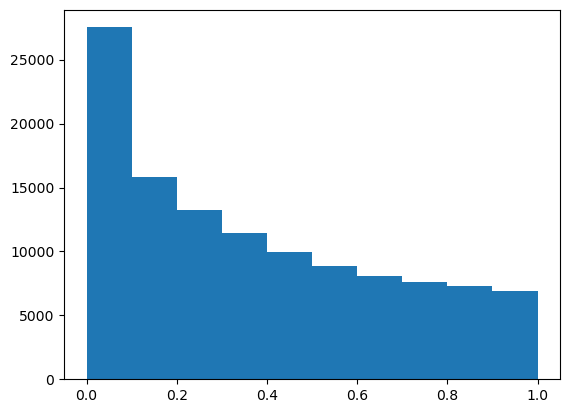

In [56]:
plt.hist(fsveg_model.p_value)

In [69]:
# cnvert back to wide
fsveg_model_wide = fsveg_model.pivot_table(index=['unique_id', 'ACRES', 'COVER_TYPE', 'STAND_ID'],
                   columns='idx',
                   values=['slope', 'p_value']).reset_index()
fsveg_model_wide.columns = ['_'.join([str(i) for i in col if i]) if isinstance(col, tuple) else col
                            for col in fsveg_model_wide.columns]

In [70]:
fsveg_model_wide

,unique_id,ACRES,COVER_TYPE,STAND_ID,p_value_NDMI,p_value_NDVI,slope_NDMI,slope_NDVI
0,0,32.25,TSF,020508550202027,0.982751,0.352831,0.000052,0.002405
1,1,74.97,TAA,020507BE0102064,0.642589,0.753014,0.002107,0.002521
2,2,19.37,TAA,022402130702113,0.180882,0.489504,-0.003962,-0.002363
3,3,29.44,TAA,020508530500592,0.650244,0.673334,0.004193,0.003694
4,4,39.30,TSF,020507990900112,0.000018,0.006873,-0.008170,-0.006213
...,...,...,...,...,...,...,...,...
58337,58531,55.96,TAA,022402190107026,0.286099,0.822950,-0.004022,-0.000891
58338,58532,15.65,TBC,020507870102265,0.117363,0.045104,0.002108,0.003470
58339,58533,26.33,TAA,020507890106105,0.086560,0.150859,0.004019,0.003099
58340,58534,63.01,GRA,020507850208034,0.003819,0.034765,0.007452,0.005997


In [ ]:
# reattch to geometry

In [73]:
id_cols = ['unique_id']
geom = fsveg_.drop_duplicates(subset=id_cols)[id_cols+['geometry']]

In [81]:
fsveg_model_geom = fsveg_model_wide.merge(geom[['unique_id', 'geometry']], on='unique_id', how='left')
fsveg_model_geom = gpd.GeoDataFrame(fsveg_model_geom, geometry='geometry', crs=geom.crs)

In [ ]:
# export

In [85]:
fp_out = home+'SUFHER/shp/fsveg_gmug.gpkg'
fsveg_model_geom.to_file(fp_out, driver="GPKG")

In [90]:
fsveg_model_geom = fsveg_model_geom.rename(columns={
    'p_value_NDMI': 'p_NDMI',
    'p_value_NDVI': 'p_NDVI'
})

In [92]:
fp_out = home+'SUFHER/shp/fsveg_gmug/fsveg_gmug.shp'
fsveg_model_geom.to_file(fp_out)

In [ ]:
########################
## TREND RASTER
########################

# abandoned for now... come back later if time

In [3]:
# # this does work, but it takes like 5 mins per tif to load
# block_size = 1024

# with rasterio.open(fps[0]) as src:
#     out_meta = src.meta.copy()
    
# out_meta.update({
#     "compress": "lzw",
#     "tiled": True,
#     "blockxsize": block_size,
#     "blockysize": block_size
# })
# out_meta

In [4]:
# def compute_slope_block(stack, time):
#     """Compute slope per pixel using linear regression (vectorized)"""
#     T, H, W = stack.shape
#     mask = ~np.isnan(stack)
#     n = mask.sum(axis=0)
#     x = time.reshape(-1, 1)

#     # Replace NaNs with 0 just for sums
#     stack_filled = np.nan_to_num(stack, nan=0.0)
#     sum_y = stack_filled.sum(axis=0)
#     sum_xy = (x * stack_filled).sum(axis=0)
#     sum_x = np.sum(time)
#     sum_x2 = np.sum(time**2)

#     numerator = n * sum_xy - sum_x * sum_y
#     denominator = n * sum_x2 - sum_x**2

#     with np.errstate(divide='ignore', invalid='ignore'):
#         slope = numerator / denominator
#         slope[n < 2] = np.nan  # if <2 points, set to NaN

#     return slope.astype(np.float32)

# arrays = [rxr.open_rasterio(p, chunks={'x': 1024, 'y': 1024}).squeeze() for p in fps] # srated 2:42 pm
# stacked = xr.concat(arrays, dim='time')  # shape: (time, y, x)